In [ ]:
!free -g

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_list = drive.ListFile({'q': "'1Ba5GUjD0yxVgPmKYjW00PyJD5MSjb7S8' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [ ]:
train_downloaded = drive.CreateFile({'id': '1KfT0IoD_jA--BWFOpFACd-6N6RxvIm5k'})
train_downloaded.GetContentFile('train.csv')

test_downloaded = drive.CreateFile({'id': '1LmWC9oDwEFI7u7iqVOdwU_v8hkYm_R2O'})
test_downloaded.GetContentFile('mergedtest.csv')

embedding_downloaded = drive.CreateFile({'id': '1eM-hTMlM3g4JjE_AjcY2ya_EzcqCgI8-'})
embedding_downloaded.GetContentFile('crawl-300d-2M.vec')

In [1]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report, precision_recall_curve

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import text, sequence
from keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, MaxPool1D
from keras.layers import Dropout, Dense, Flatten

/home/hassaan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
trainfile = './data/train.csv'
testfile = './data/mergedtest.csv'
embeddingfile = './embeddings/crawl-300d-2M.vec'

max_features = 100000
max_len = 200
embed_size = 300

modelname = 'CNN1D'
batch_size = 256
epochs = 3

modelfilename = './models/model_' + modelname + '.h5'

In [3]:
df = pd.read_csv(trainfile)
dftest = pd.read_csv(testfile)

In [4]:
print('train set has', df.shape[0], 'rows and', df.shape[1], 'columns')
print('test set has', dftest.shape[0], 'rows and', dftest.shape[1], 'columns')

train set has 159571 rows and 8 columns
test set has 63978 rows and 8 columns


In [5]:
df.comment_text = df.comment_text.apply( lambda x: np.nan if len(str(x)) <= 1 else x )
df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
df[df['comment_text'].isnull()]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [7]:
df.dropna( inplace=True )
print( 'train set shape:', df.shape )
print( 'test set shape:', dftest.shape )

train set shape: (159571, 8)
test set shape: (63978, 8)


In [8]:
df.comment_text = df.comment_text.astype(str)
dftest.comment_text = dftest.comment_text.astype(str)

In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

tokenizer = text.Tokenizer( num_words=max_features )
tokenizer.fit_on_texts( df.comment_text )

print( 'Vocabulary Size:', tokenizer.num_words )

Vocabulary Size: 100000


In [10]:
xtrain = tokenizer.texts_to_sequences( df.comment_text.values )
xtrain = sequence.pad_sequences( xtrain, maxlen=max_len )

xtest = tokenizer.texts_to_sequences( dftest.comment_text.values )
xtest = sequence.pad_sequences( xtest, maxlen=max_len )

ytrain = df[ labels ].values

gc.collect()

0

#### Loading FastText embedding

In [11]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open( embeddingfile, encoding='utf-8' ))

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

del embeddings_index
embeddings_index = None

print ( 'Embedding Matrix Shape:', embedding_matrix.shape )

gc.collect()

Embedding Matrix Shape: (100000, 300)


0

In [12]:
K.clear_session()

#### The Model

In [13]:
def focal_loss(gamma=5., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [14]:
model = Sequential()
e = Embedding( max_features, embed_size, weights=[embedding_matrix], name='Embedding', input_length=max_len, trainable=True )
model.add( e )

model.add( SpatialDropout1D( 0.4, name='SpatialDropout1D' ) )

model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv11' ) )
model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv12' ) )
model.add( MaxPool1D( name='MaxPool1' ) )

model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv21' ) )
model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv22' ) )
model.add( MaxPool1D( name='MaxPool2' ) )

model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv31' ) )
model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv32' ) )
model.add( MaxPool1D( name='MaxPool3' ) )

model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv41' ) )
model.add( Conv1D( 32, 3, padding='valid', activation='elu', name='Conv42' ) )
model.add( MaxPool1D( name='MaxPool4' ) )

model.add( Flatten( name='Flatten' ) )

model.add( Dropout( 0.1, name='DropoutConcat' ) )

model.add( Dense( 100, activation='elu', name='FC1' ) )
model.add( Dense( 50, activation='elu', name='FC2' ) )
model.add( Dense( 6, activation='sigmoid', name='outputFC' ) )

model.compile( loss=[focal_loss(alpha=.25, gamma=5)],
              optimizer='adam', metrics=['accuracy'] )
model.summary(  )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 200, 300)          30000000  
_________________________________________________________________
SpatialDropout1D (SpatialDro (None, 200, 300)          0         
_________________________________________________________________
Conv11 (Conv1D)              (None, 198, 32)           28832     
_________________________________________________________________
Conv12 (Conv1D)              (None, 196, 32)           3104      
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 98, 32)            0         
_________________________________________________________________
Conv21 (Conv1D)              (None, 96, 32)            3104      
_________________________________________________________________
Conv22 (Conv1D)              (None, 94, 32)            3104      
__________

#### Train and Save the Model

In [15]:
hist = model.fit( xtrain, ytrain, batch_size=batch_size, epochs=epochs, verbose=1 )
model.save(modelfilename)

Epoch 1/3
159571/159571 [==============================] - 79s 494us/step - loss: 2.6016 - acc: 0.9104
Epoch 2/3
159571/159571 [==============================] - 75s 472us/step - loss: 2.0683 - acc: 0.9662
Epoch 3/3
159571/159571 [==============================] - 76s 473us/step - loss: 1.9555 - acc: 0.9770


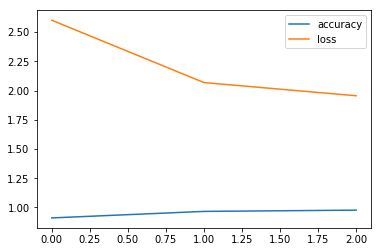

In [16]:
plt.plot( hist.history['acc'], label='accuracy' )
plt.plot( hist.history['loss'], label='loss' )
plt.legend( loc='best' )
plt.show()

#### Collect the Garbage

In [17]:
#del model
#model = None

gc.collect()

20748

#### Load the Model that was saved previously

In [18]:
#loaded_model = load_model( modelfilename )
loaded_model = model

#### Getting Predictions for Traning Set

In [19]:
trainpredictions = loaded_model.predict( xtrain, verbose=1, batch_size=512 )

159571/159571 [==============================] - 9s 54us/step


#### Average ROC AUC per Column (training)

In [20]:
train_acc = accuracy_score( df[labels].values, (trainpredictions>=0.5).astype('int64') )
train_acc

0.9057848857248497

In [21]:
train_rocs = [roc_auc_score(df[lbl], trainpredictions[:,i]) for i, lbl in enumerate(labels)]
print('Average ROC AUC score per column (training):', np.mean(train_rocs))

Average ROC AUC score per column (training): 0.9309010439626922


#### Getting Predictions for Test Set

In [22]:
testpredictions = loaded_model.predict( xtest, verbose=1, batch_size=512 )

63978/63978 [==============================] - 3s 54us/step


#### Average ROC AUC per Column (test)

In [23]:
test_acc = accuracy_score( dftest[labels].values, (testpredictions>=0.5).astype('int64') )
test_acc

0.8994654412454282

In [24]:
test_rocs = [roc_auc_score(dftest[lbl], testpredictions[:,i]) for i, lbl in enumerate(labels)]
print('Average ROC AUC score per column (testing):', np.mean(test_rocs))

Average ROC AUC score per column (testing): 0.8693028733427997


In [25]:
print(classification_report( dftest[labels].values, (testpredictions>=0.5).astype('int64') ))

             precision    recall  f1-score   support

          0       0.68      0.21      0.32      6090
          1       0.00      0.00      0.00       367
          2       0.78      0.19      0.31      3691
          3       0.00      0.00      0.00       211
          4       0.79      0.15      0.25      3427
          5       0.00      0.00      0.00       712

avg / total       0.67      0.17      0.27     14498



/home/hassaan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [36]:
from sklearn.metrics import precision_score
precision_score(dftest.toxic, (testpredictions[:,0]>=0.5).astype('int64') )

0.6810299527062533

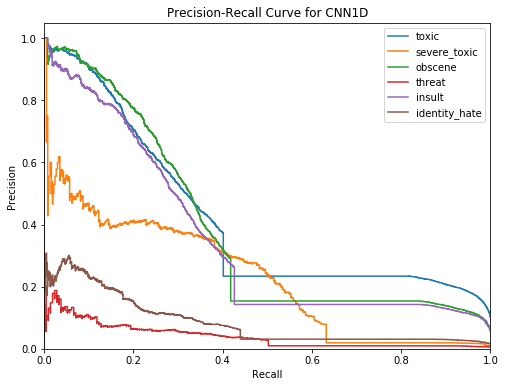

In [26]:
plt.figure(figsize=(8, 6))
for i, lbl in enumerate(labels):
    precision, recall, _ = precision_recall_curve(dftest[lbl], testpredictions[:,i])
    plt.step(recall, precision, where='post', label='{0}'.format(labels[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title( 'Precision-Recall Curve for {0}'.format(modelname) )
plt.legend(loc='upper right')
plt.show()

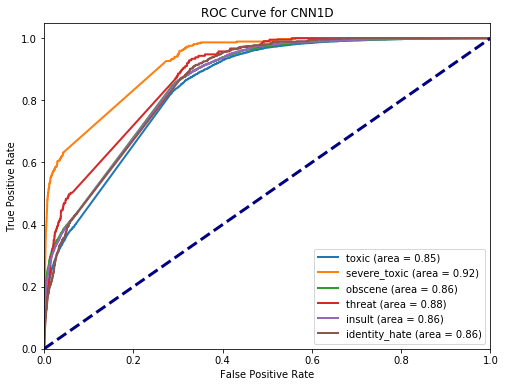

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, lbl in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve( dftest[lbl], testpredictions[:,i] )
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range( len(labels) ):
    plt.plot(fpr[i], tpr[i], lw=2, label='{0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], '--', lw=3, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for {0}'.format(modelname))
plt.legend(loc="lower right")
plt.show()

In [28]:
gc.collect()

6244